In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import csv
from data.create_dataset import create_dataset
from data.load import load_dataset
import seaborn as sns

from collections import deque

def exhaust(generator):
    deque(generator, maxlen=0)

import warnings
warnings.filterwarnings("ignore")

br_types = ['mdamb231', 'mcf7']
cell_types = sorted(['hela', 'preo', 'lclc', 'mdamb231',  'breastcancer', 'mcf7'])
SRC_PATH = '../data_paths.txt'
DEST_PATH = '/media/balint/Backup1/data/1d-class-datasets/interpolated-4th-run/'
datasets = ["hela-mdamb231-mcf7-lclc", "mdamb231-mcf7", "mdamb231-mcf7-lclc", "preo-hela-mdamb231-mcf7-lclc", "hela-breastcancer-lclc", "breastcancer-lclc", "preo-hela-breastcancer-lclc"]
times = ['0.5hrs', '1hrs', '1.5hrs', '2hrs']

In [2]:
for ds in datasets:
    exhaust(create_dataset(DEST_PATH, os.path.join(DEST_PATH, ds), ds.split('-'), [int(t * 60 / 9) for t in [30, 60, 90, 120, 150]], .2))

[932, 387, 1204, 1665]
Counter({3: 1332, 2: 963, 0: 745, 1: 309}) Counter({3: 333, 2: 241, 0: 187, 1: 78})
Counter({3: 1332, 2: 963, 0: 745, 1: 309}) Counter({3: 333, 2: 241, 0: 187, 1: 78})
Counter({3: 1332, 2: 963, 0: 745, 1: 309}) Counter({3: 333, 2: 241, 0: 187, 1: 78})
[932, 387, 387, 1665]
Counter({3: 1332, 0: 745, 1: 309, 2: 309}) Counter({3: 333, 0: 187, 1: 78, 2: 78})
Counter({3: 1332, 0: 745, 1: 309, 2: 309}) Counter({3: 333, 0: 187, 1: 78, 2: 78})
[1204, 1665]
Counter({1: 1332, 0: 963}) Counter({1: 333, 0: 241})
Counter({1: 1332, 0: 963}) Counter({1: 333, 0: 241})
Counter({1: 1332, 0: 963}) Counter({1: 333, 0: 241})
[387, 1665]
Counter({1: 1332, 0: 309}) Counter({1: 333, 0: 78})
Counter({1: 1332, 0: 309}) Counter({1: 333, 0: 78})
[387, 1204, 1665]
Counter({2: 1332, 1: 963, 0: 309}) Counter({2: 333, 1: 241, 0: 78})
Counter({2: 1332, 1: 963, 0: 309}) Counter({2: 333, 1: 241, 0: 78})
Counter({2: 1332, 1: 963, 0: 309}) Counter({2: 333, 1: 241, 0: 78})
[387, 387, 1665]
Counter({2

In [2]:
X_train, y_train, X_test, y_test, (tags, labels) = load_dataset(os.path.join(DEST_PATH, datasets[0], str(60)), scale=False)

train shape: (3349, 400), test shape: (839, 400)
train: [(array([0, 1, 2, 3]),), (array([1332, 1332, 1332, 1332]),)]
test: [(array([0, 1, 2, 3]),), (array([187,  78, 241, 333]),)]


In [ ]:
# with open(SRC_PATH, 'r') as fp:
#     for file_path in fp.readlines():
#         file_path = file_path.strip()
#         tp = file_path.split('/')[-1].split('_')[0].lower()
#         if tp in cell_types:
#             print(file_path, tp, os.path.exists(file_path))
#             res_max_path = os.path.join(DEST_PATH, f'{tp}_max_signals.csv')
#             lines = pd.read_csv(file_path, header=None)
#             time = np.round(np.array(lines.iloc[0, :]), 0).astype(int)
#             signals = np.array(lines.iloc[1:, :])
            
#             d = []
#             for i in range(signals.shape[0]):
#                 if np.min(signals[i]) <= -100:
#                     d.append(i)
            
#             signals = np.delete(signals, d, axis=0)
            
#             diff = np.diff(np.mean(signals, axis=0))
#             err = np.argwhere(np.logical_or(diff > 5, diff < -5))
#             err = err.reshape((-1,))
#             err.sort()
#             peaks = np.argwhere(np.diff(err) == 1)
#             peaks = peaks.reshape((-1, ))
#             err = np.unique(np.concatenate([err[peaks], err[peaks + 1]]))
#             data_range = np.arange(signals.shape[1])
#             org = data_range.copy()
#             data_range = np.delete(data_range, err, axis=0)
            
#             data = signals
        
#             time_avg_max = np.round(np.mean(np.diff(time)), 0)
            
#             new_data = np.zeros(data.shape)
#             data = np.delete(data, err, axis=1)
#             for i in range(new_data.shape[0]):
#                 new_data[i] = np.interp(org, data_range, data[i])
#             data = new_data

#             interpolate = False
#             if time_avg_max == 12:
#                 interpolate = True
#                 new_time = np.round(np.linspace(0,max(time), int(max(time) / 3)),0).astype(int)
#                 new_time_red = np.interp(new_time, time, time)[:None:3]
                
#             if interpolate:
#                 print(f'Interpolating {file_path}')
#                 new_data = np.zeros((data.shape[0], new_time_red.shape[0]))
#                 for i in range(data.shape[0]):
#                     new_data[i] = np.interp(new_time_red, time, data[i])
#                 data = new_data
                
#             for i in range(data.shape[0]):
#                 data[i] -= data[i, 0]

#             pd.DataFrame(data).to_csv(res_max_path, mode='a', header=None, index=None)
            
#             if tp in br_types:
#                 pd.DataFrame(data).to_csv(os.path.join(DEST_PATH, f'breastcancer_max_signals.csv'), mode='a', header=None, index=None)
            


In [ ]:
# times = [30, 60, 90, 120, 150]
# for t in times:
#     ln = int(t * 60 / 9)
#     plt.figure()
#     for tp in cell_types:
#         res_max_path = os.path.join(DEST_PATH, f'{tp}_max_signals.csv')
#         if os.path.exists(res_max_path):
#             data = []
#             fp = open(res_max_path, 'r')
#             reader = csv.reader(fp)
#             for line in reader:
#                 if len(line) >= ln:
#                     line = list(map(float, line))[:ln]
#                     data.append(line)
#             data = np.asarray(data)
#             print(tp, data.shape)
#             plt.plot(np.mean(data, axis=0), label=tp)
#     plt.legend()
#     plt.show()


In [ ]:
# for i, t in enumerate(times):
#     for ds in datasets:
#         if not os.path.exists(os.path.join(DEST_PATH, str(t), ds)):
#             os.makedirs(os.path.join(DEST_PATH, str(t), ds))
#         typs = sorted(ds.split('-'))
#         labels = list(range(len(typs)))
#         data = []
#         for tp in typs:
#             res_max_path = os.path.join(DEST_PATH, f'{tp}_max_signals.csv')
#             if os.path.exists(res_max_path):
#                 fp = open(res_max_path, 'r')
#                 reader = csv.reader(fp)
#                 for line in reader:
#                     if len(line) >= ln:
#                         line = list(map(float, line))[:ln]
#                         data.append(line)
#         data = np.asarray(data)
        
#         pd.DataFrame(list(zip(typs, labels)), columns=['type', 'tag']).to_csv(os.path.join(DEST_PATH, str(t), ds, 'dictionary.csv'), index=None)

In [10]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

def load_dataset(path, resample=True, scale=True):
    X_train = np.array(pd.read_csv(os.path.join(path, 'X_train.csv'), header=None))
    y_train = np.array(pd.read_csv(os.path.join(path, 'y_train.csv'), header=None)).squeeze()
    X_test = np.array(pd.read_csv(os.path.join(path, 'X_test.csv'), header=None))
    y_test = np.array(pd.read_csv(os.path.join(path, 'y_test.csv'), header=None)).squeeze()
    dictionary = pd.read_csv(os.path.join(path, 'dictionary.csv'), header=None)
    tags, labels = list(dictionary.iloc[:, 0]), list(dictionary.iloc[:, 1])
    
    print(f"train shape: {X_train.shape}, test shape: {X_test.shape}")
    
    if resample:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    
    print('train:', list(zip(np.unique(y_train, return_counts=True))))
    print('test:', list(zip(np.unique(y_test, return_counts=True))))
    
    train = list(zip(X_train, y_train))
    random.shuffle(train)
    X_train, y_train = zip(*train)
    
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_train)
        
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        return *list(map(np.array, [X_train, y_train, X_test, y_test])), (tags, labels), scaler
    
    return *list(map(np.array, [X_train, y_train, X_test, y_test])), (tags, labels)
        

In [11]:
X_train, y_train, X_test, y_test, tag_conv = load_dataset(os.path.join(DEST_PATH, datasets[0], str(120)), scale=False)
X_train2, y_train2, _, _, _ = load_dataset(os.path.join(DEST_PATH, datasets[0], str(120)), resample=False, scale=False)
y_train.shape, y_train2.shape

train shape: (2695, 800), test shape: (676, 800)
(5328,) (676,)
train: [(array([0, 1, 2, 3]),), (array([1332, 1332, 1332, 1332]),)]
test: [(array([0, 1, 2, 3]),), (array([187,  78,  78, 333]),)]
train shape: (2695, 800), test shape: (676, 800)
(2695,) (676,)
train: [(array([0, 1, 2, 3]),), (array([ 745,  309,  309, 1332]),)]
test: [(array([0, 1, 2, 3]),), (array([187,  78,  78, 333]),)]


((5328,), (2695,))

In [12]:
X_train.shape, y_train.shape, X_test.shape

((5328, 800), (5328,), (676, 800))

In [13]:
np.unique(y_train, return_counts=True), np.unique(y_train2, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2, 3]), array([1332, 1332, 1332, 1332])),
 (array([0, 1, 2, 3]), array([ 745,  309,  309, 1332])),
 (array([0, 1, 2, 3]), array([187,  78,  78, 333])))

(1332, 800) (745, 800)


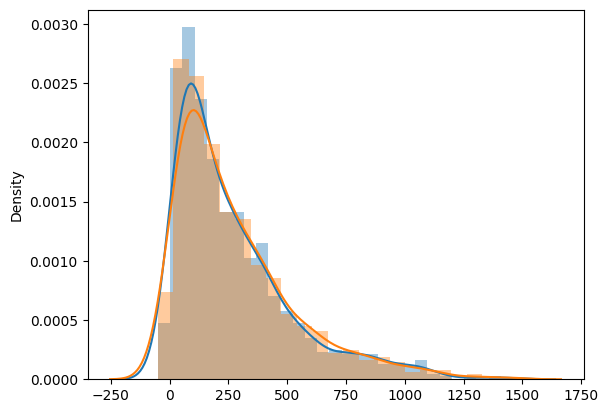

(1332, 800) (309, 800)


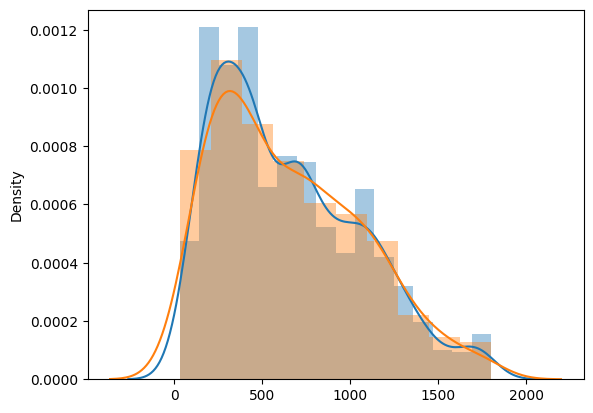

(1332, 800) (309, 800)


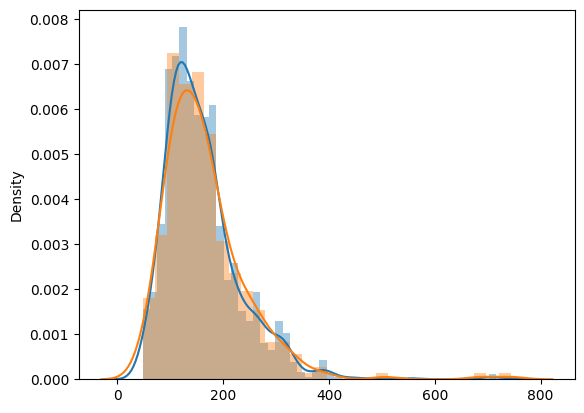

(1332, 800) (1332, 800)


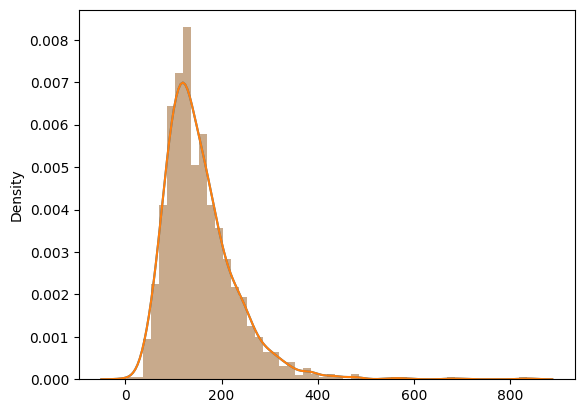

In [14]:
for i in np.unique(y_train):
    fig, ax = plt.subplots(1,1)
    d = X_train[y_train == i]
    d2 = X_train2[y_train2.squeeze() == i]
    print(d.shape, d2.shape)
    sns.distplot(d[:,-1], ax=ax)
    sns.distplot(d2[:,-1], ax=ax)
    plt.show()